In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:13<00:00, 92.6MB/s]
100% 1.14G/1.14G [00:13<00:00, 90.3MB/s]


In [ ]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential,Model
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D

import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import DenseNet121

from imgaug import augmenters

In [ ]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [ ]:
batch_size = 32

img_height = 75
img_width = 75

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


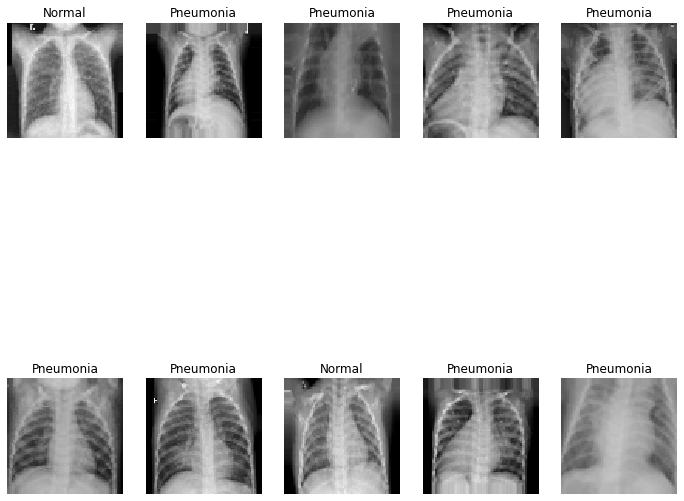

In [ ]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [ ]:
!pwd

/content


In [ ]:
!ls

dataset  drive	kaggle.json  pneumonia-xray-images.zip	sample_data


In [ ]:
%cd '/content'

/content


In [ ]:
dense_net_121 = DenseNet121(input_shape=(img_width,img_height,3),include_top=False,pooling='avg')

base_model_output = Dense(units=14,activation='relu')(dense_net_121.output)
base_model = Model(inputs=dense_net_121.input,outputs=base_model_output)

base_model.load_weights('/content/drive/MyDrive/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

for layer in base_model.layers[:10]:
  layer.trainable = False

output_layer = Dense(1,activation='sigmoid')(base_model.layers[-2].output)
model = Model(inputs=base_model.inputs, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 81, 81, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 38, 38, 64)   9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.690719 to fit



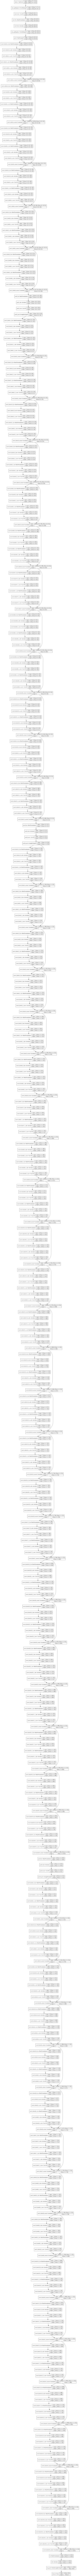

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [ ]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [32]:
model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
131/131 [==============================] - 376s 3s/step - loss: 0.3083 - accuracy: 0.8404 - val_loss: 0.1817 - val_accuracy: 0.9462
Epoch 2/25
131/131 [==============================] - 364s 3s/step - loss: 0.1179 - accuracy: 0.9498 - val_loss: 0.1873 - val_accuracy: 0.9221
Epoch 3/25
131/131 [==============================] - 364s 3s/step - loss: 0.1088 - accuracy: 0.9571 - val_loss: 0.6956 - val_accuracy: 0.7635
Epoch 4/25
131/131 [==============================] - 363s 3s/step - loss: 0.0951 - accuracy: 0.9650 - val_loss: 0.2159 - val_accuracy: 0.9144
Epoch 5/25
131/131 [==============================] - 360s 3s/step - loss: 0.0797 - accuracy: 0.9668 - val_loss: 0.3542 - val_accuracy: 0.8404
Epoch 6/25
131/131 [==============================] - 359s 3s/step - loss: 0.0902 - accuracy: 0.9560 - val_loss: 0.1652 - val_accuracy: 0.9346
Epoch 7/25
131/131 [==============================] - 361s 3s/step - loss: 0.0589 - accuracy: 0.9714 - val_loss: 0.4256 - val_accuracy: 0.8404

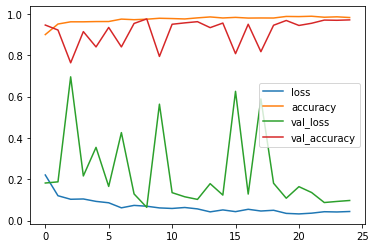

In [33]:
pd.DataFrame(model.history.history).plot()

In [35]:
test_acc = model.evaluate(test)
print('The testing accuracy is - ',test_acc[1]*100,'%')

20/20 [==============================] - 14s 653ms/step - loss: 0.3658 - accuracy: 0.9135
The testing accuracy is -  91.34615659713745 %


In [36]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [37]:
y_bar = np.round(model.predict(test)).reshape(-1)
y_act = test.labels

In [38]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.9134615384615384
ROC-AUC score:  0.9273076000959004
F1 score:  0.9341463414634147
Log Loss:  2.9889415424794694
